# 数据导入

In [1]:
import pandas as pd
from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import zero_one_loss
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_gaussian_quantiles
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
'''
DATASET SOURCE is from httpsgithub.comarjbahnsl-kdd.git (include the most attack types)
httpsgithub.comdefcom17NSL_KDD.git'''

train_file = 'https://raw.githubusercontent.com/arjbah/nsl-kdd/master/nsl-kdd/KDDTrain%2B.txt'
test_file = 'https://raw.githubusercontent.com/arjbah/nsl-kdd/master/nsl-kdd/KDDTest%2B.txt'
field_name_file = 'https://raw.githubusercontent.com/defcom17/NSL_KDD/master/Field%20Names.csv'
attack_type_file = 'https://raw.githubusercontent.com/arjbah/nsl-kdd/master/training_attack_types.txt'

#read and add the colname of data
filename=pd.read_csv(field_name_file,header=None,names=["name","type"])
colname=filename["name"].tolist()
colname+=("label","useless")

#read train and test data
train=pd.read_csv(train_file,header=None,names=colname)
test=pd.read_csv(test_file,header=None,names=colname)

#最后一列没有用，删去

train.drop("useless",axis=1,inplace=True)
test.drop("useless",axis=1,inplace=True)


#读入攻击类型
attack_type=pd.read_csv(attack_type_file,sep=' ',header=None)#注意这里的sep！！！！

#将数据的攻击类型进行分类
def fiveclass(x):
    if x=='normal': return 'normal'
    return np.array(attack_type[attack_type[0]==x])[0,1]
train["label"]=train["label"].map(fiveclass)
test["label"]=test["label"].map(fiveclass)





# 简单查看数据

In [2]:
print(train.groupby('label').size())
print(test.groupby('label').size())


from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

oe=OrdinalEncoder()
le=LabelEncoder()
train.iloc[:,1:4]=oe.fit_transform((train.iloc[:,1:4]))
train.loc[:,'label']=le.fit_transform(train.loc[:,'label'])

test.iloc[:,1:4]=oe.fit_transform(test.iloc[:,1:4])
test.loc[:,'label']=le.fit_transform(test.loc[:,'label'])

print(train.groupby('label').size())
print(test.groupby('label').size())

label
dos       45927
normal    67343
probe     11656
r2l         995
u2r          52
dtype: int64
label
dos       7636
normal    9711
probe     2421
r2l       2576
u2r        200
dtype: int64
label
0    45927
1    67343
2    11656
3      995
4       52
dtype: int64
label
0    7636
1    9711
2    2421
3    2576
4     200
dtype: int64


C:\Users\MS\AppData\Local\Temp\ipykernel_20656\1010330431.py:10: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.iloc[:,1:4]=oe.fit_transform((train.iloc[:,1:4]))
C:\Users\MS\AppData\Local\Temp\ipykernel_20656\1010330431.py:11: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:,'label']=le.fit_transform(train.loc[:,'label'])
C:\Users\MS\AppData\Local\Temp\ipykernel_20656\1010330431.py:13: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the

划分训练集，测试集，xy

In [3]:
x_train=train.drop('label',axis=1)
x_test=test.drop('label',axis=1)
xi=test[test['label']==4].drop('label',axis=1)


y_train=train['label']
y_test=test['label']
yi=test[test['label']==4]['label']

# 尝试传统集成模型

In [4]:
from sklearn.metrics import precision_score


base=DecisionTreeClassifier(max_depth=10)
mod1=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt')


mod1.fit(x_train,y_train)
mod2.fit(x_train,y_train)
mod3.fit(x_train,y_train)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))

y1=mod1.predict(xi)
y2=mod2.predict(xi)
y3=mod3.predict(xi)
print(precision_score(y1,yi,average='micro'))
print(precision_score(y2,yi,average='micro'))
print(precision_score(y3,yi,average='micro'))

0.7300390347764372
0.7445440028388929
0.742680979418027
0.01
0.01
0.01


In [5]:
from collections import Counter
from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC

from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

# 数据分析
观察到，数据为典型的不平衡数据，所以使用过采样，欠采样和调整权重

随机欠采样

In [6]:

from imblearn.under_sampling import RandomUnderSampler 
ru=RandomUnderSampler(sampling_strategy={0:70,1:90,2:70,3:70,4:50},random_state=42)
x1,y1=ru.fit_resample(x_train,y_train)
print('Resampled dataset shape %s' % Counter(y1))


Resampled dataset shape Counter({1: 90, 0: 70, 2: 70, 3: 70, 4: 50})


In [7]:
from sklearn.metrics import precision_score


base=DecisionTreeClassifier(max_depth=10)
mod1=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt')


mod1.fit(x_train,y_train)
mod2.fit(x_train,y_train)
mod3.fit(x_train,y_train)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))

y1=mod1.predict(xi)
y2=mod2.predict(xi)
y3=mod3.predict(xi)
print(precision_score(y1,yi,average='micro'))
print(precision_score(y2,yi,average='micro'))
print(precision_score(y3,yi,average='micro'))

0.7333215046132009
0.7418825408090844
0.747028034066714
0.005
0.015
0.02


ClusterCentroids

In [8]:
x_train=train.drop('label',axis=1)
x_test=test.drop('label',axis=1)
y_train=train['label']
y_test=test['label']


from imblearn.under_sampling import ClusterCentroids 
cc=ClusterCentroids(sampling_strategy={0:70,1:80,2:70,3:60,4:50},random_state=42)
x1,y1=cc.fit_resample(x_train,y_train)
print('Resampled dataset shape %s' % Counter(y1))

Resampled dataset shape Counter({1: 80, 0: 70, 2: 70, 3: 60, 4: 50})


In [ ]:
from sklearn.metrics import precision_score


base=DecisionTreeClassifier(max_depth=10)
mod1=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt')


mod1.fit(x_train,y_train)
mod2.fit(x_train,y_train)
mod3.fit(x_train,y_train)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))

y1=mod1.predict(xi)
y2=mod2.predict(xi)
y3=mod3.predict(xi)
print(precision_score(y1,yi,average='micro'))
print(precision_score(y2,yi,average='micro'))
print(precision_score(y3,yi,average='micro'))

0.7346965933286018
0.7388662171753017
0.7425922640170334
0.005
0.01
0.015


TomekLinks

In [9]:
from imblearn.under_sampling import TomekLinks
tl=TomekLinks()
x1,y1=tl.fit_resample(x_train,y_train)
print('Resampled dataset shape %s' % Counter(y1))

Resampled dataset shape Counter({1: 67299, 0: 45904, 2: 11626, 3: 981, 4: 52})


In [ ]:
from sklearn.metrics import precision_score


base=DecisionTreeClassifier(max_depth=10)
mod1=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt')


mod1.fit(x_train,y_train)
mod2.fit(x_train,y_train)
mod3.fit(x_train,y_train)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))

y1=mod1.predict(xi)
y2=mod2.predict(xi)
y3=mod3.predict(xi)
print(precision_score(y1,yi,average='micro'))
print(precision_score(y2,yi,average='micro'))
print(precision_score(y3,yi,average='micro'))

0.7292405961674947
0.7382452093683464
0.7495120652945352


 过采样和欠采样组合方法 SMOTETomek (SMOTE + Tomeklinks) 和 SMOTEENN (SMOTE + Edited Nearest Neighbours)。其中，SMOTEENN 比 SMOTETomek 更容易清除噪声样本

In [10]:
from imblearn.combine import SMOTETomek, SMOTEENN

# 实例化类对象
smote_enn = SMOTEENN(random_state=0)
# 生成新数据集
x1, y1 = smote_enn.fit_resample(x_train, y_train)

In [ ]:
print('Resampled dataset shape %s' % Counter(y1))

Resampled dataset shape Counter({4: 67177, 0: 67080, 3: 67013, 2: 67012, 1: 66333})


In [ ]:
base=DecisionTreeClassifier(max_depth=10,min_samples_leaf=5)
mod1=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt',min_samples_leaf=5)


mod1.fit(x1,y1)
mod2.fit(x1,y1)
mod3.fit(x1,y1)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))

In [58]:
from imblearn.combine import SMOTETomek, SMOTEENN

# 实例化类对象
smote_enn = SMOTEENN(random_state=0)
smote_tomek = SMOTETomek(random_state=0)
x1, y1 = smote_tomek.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y1))

KeyboardInterrupt: 

In [ ]:
base=DecisionTreeClassifier(max_depth=10,min_samples_leaf=5)
mod1=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=400,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt',min_samples_leaf=5)


mod1.fit(x1,y1)
mod2.fit(x1,y1)
mod3.fit(x1,y1)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))

smote算法

In [145]:
def plot_decision_function(X, y, clf, ax):
    """Plot the decision function of the classifier and the original data"""
    plot_step = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, plot_step), np.arange(y_min, y_max, plot_step)
    )

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], alpha=0.8, c=y, edgecolor="k")
    ax.set_title(f"Resampling using {clf[0].__class__.__name__}")

In [146]:
def plot_resampling(X, y, sampler, ax):
    """Plot the resampled dataset using the sampler."""
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    sns.despine(ax=ax, offset=10)
    ax.set_title(f"Decision function for {sampler.__class__.__name__}")
    return Counter(y_res)

C:\Users\MS\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


InvalidIndexError: (slice(None, None, None), 0)

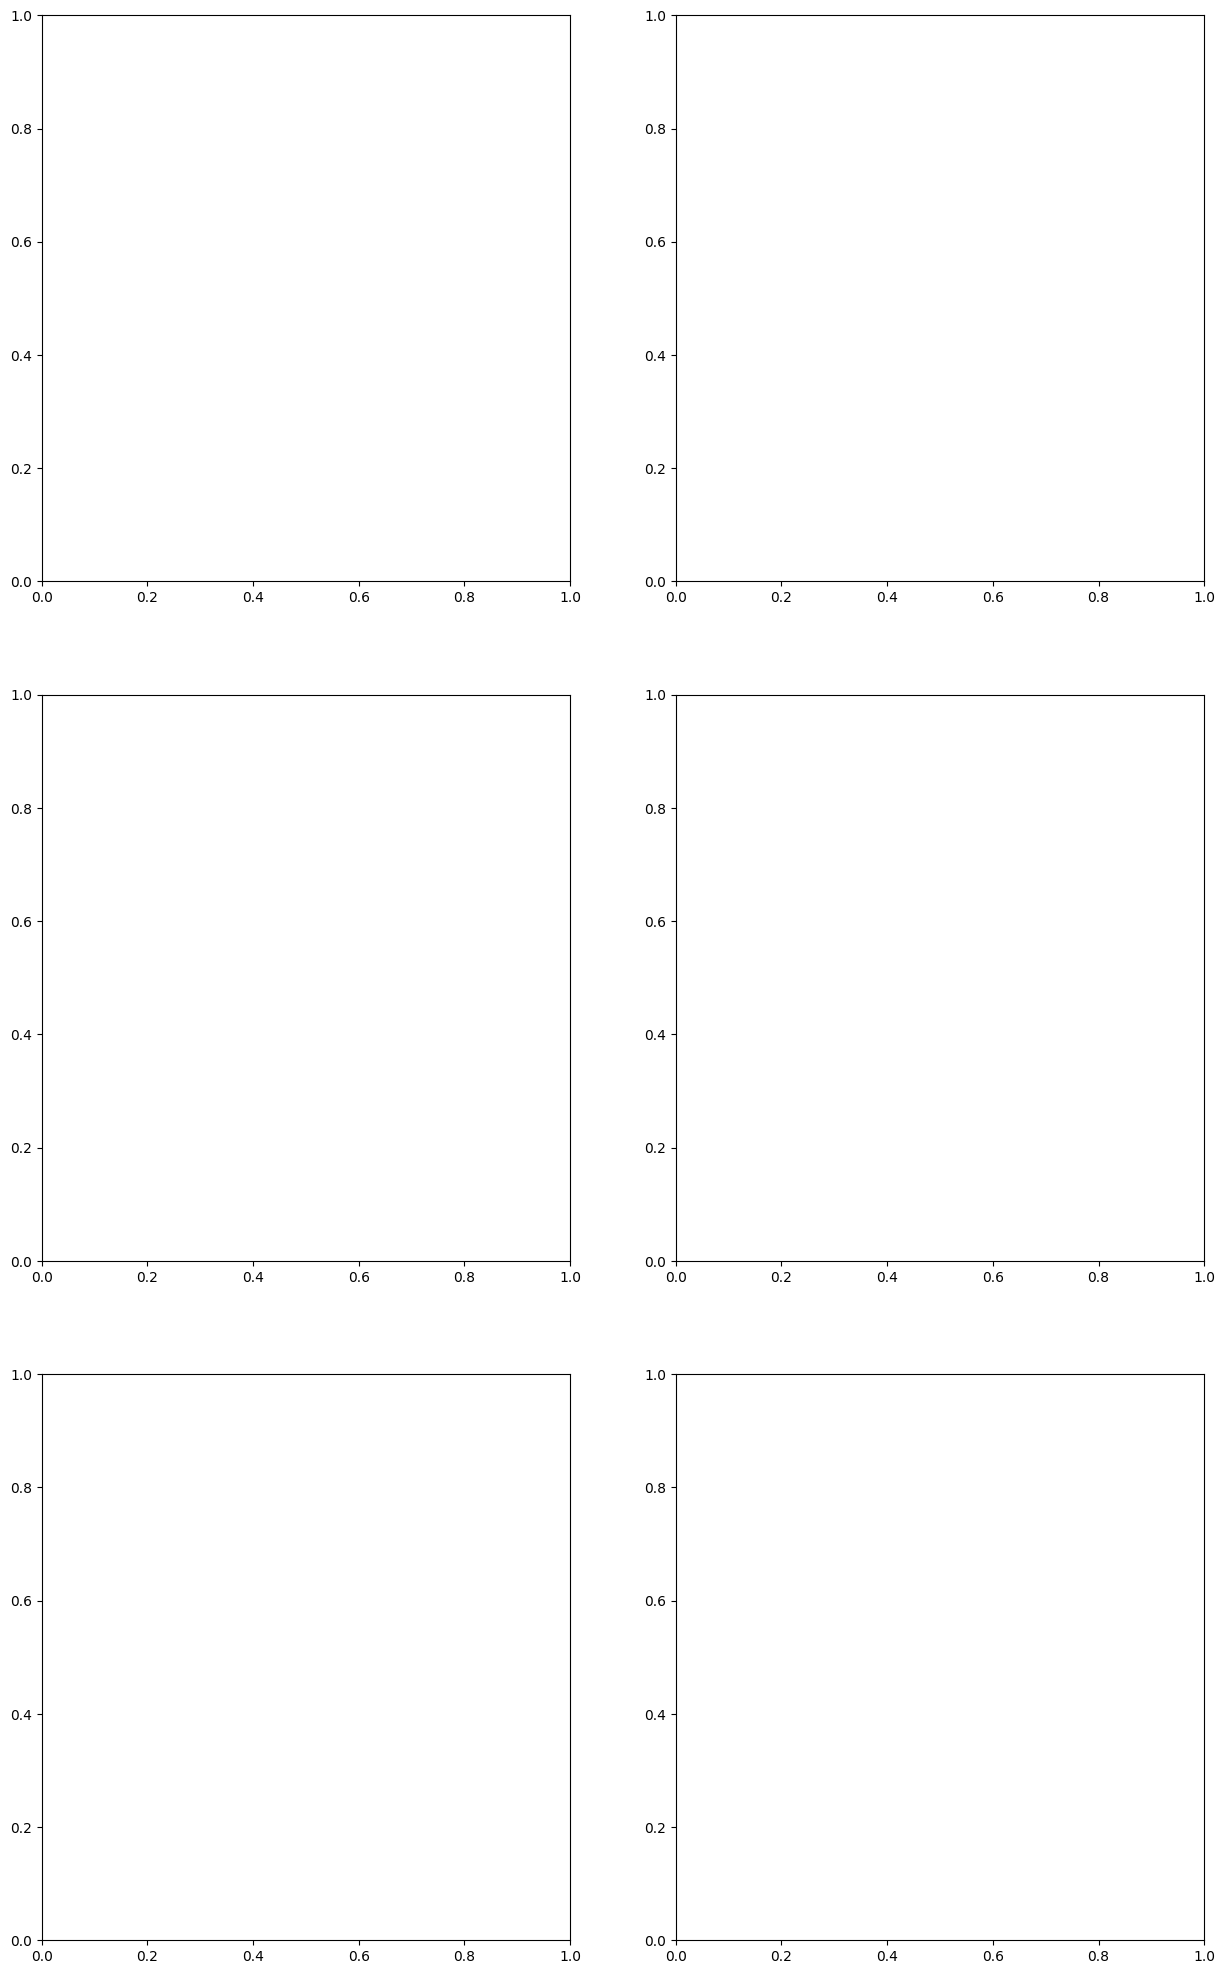

In [147]:


samplers = [SMOTE(random_state=0), SMOTEENN(random_state=0), SMOTETomek(random_state=0)]
fig, axs = plt.subplots(3, 2, figsize=(15, 25))

for ax, sampler in zip(axs, samplers):
    clf = make_pipeline(sampler, LinearSVC()).fit(x_train, y_train)
    plot_decision_function(x_train, y_train, clf, ax[0])
    plot_resampling(x_train, y_train, sampler, ax[1])


sm = SMOTE(random_state=42,k_neighbors=5)#random为随机种子，k——neighbors为找k个最近的同类

x_res, y_res = sm.fit_resample(x_train, y_train,)
print('Resampled dataset shape %s' % Counter(y_res))


In [142]:
base=DecisionTreeClassifier(max_depth=10)
mod1=AdaBoostClassifier(base,n_estimators=300,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=300,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt')


mod1.fit(x_res,y_res)
mod2.fit(x_res,y_res)
mod3.fit(x_res,y_res)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))

KeyboardInterrupt: 

Borderline SMOTE

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE

sm = BorderlineSMOTE(random_state=42,kind="borderline-1")
x_res, y_res = sm.fit_resample(x_train, y_train)
print('Resampled dataset shape %s' % Counter(y_res))

In [ ]:
base=DecisionTreeClassifier(max_depth=10)
mod1=AdaBoostClassifier(base,n_estimators=300,algorithm="SAMME")
mod2=AdaBoostClassifier(base,n_estimators=300,algorithm="SAMME.R")
mod3=RandomForestClassifier(n_estimators=70,max_features='sqrt')


mod1.fit(x_res,y_res)
mod2.fit(x_res,y_res)
mod3.fit(x_res,y_res)
y1=mod1.predict(x_test)
y2=mod2.predict(x_test)
y3=mod3.predict(x_test)
print(precision_score(y1,y_test,average='micro'))
print(precision_score(y2,y_test,average='micro'))
print(precision_score(y3,y_test,average='micro'))